In [1]:
# ============================================================
# - SentiHood Aspect Based Sentiment Analyses — Fine-tune from your IMDb best models
# - Discovers .../models/*/best_model/ in Drive
# - Converts SentiHood into (sentence, aspect) pairs
# - Replaces classifier head -> 3 labels: negative / none / positive
# - Saves MODEL-ONLY best snapshot to best_model_sentihood/
# - Deletes optimizer/scheduler checkpoints DURING training
# ============================================================

<h1> STEP 0: Install & setup (Colab) </h1>

In [2]:
# !pip install -q transformers datasets accelerate scikit-learn

In [3]:
!pip install -q "transformers>=4.35" "datasets>=2.14" "accelerate>=0.21" scikit-learn pandas matplotlib gradio

In [4]:
import os, re, json, random, numpy as np, torch, pandas as pd, matplotlib.pyplot as plt
from typing import List, Dict, Any, Optional, Tuple
from dataclasses import dataclass

# Silence external loggers/integrations
os.environ["WANDB_MODE"] = "disabled"
os.environ["WANDB_DISABLED"] = "true"
os.environ["HF_HUB_DISABLE_TELEMETRY"] = "1"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Repro
SEED = 42
random.seed(SEED); np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


<h1> STEP 1: Constants & paths </h1>

In [6]:
from datasets import load_dataset, Dataset, DatasetDict

DATASET_NAME = "bhavnicksm/sentihood"

ASPECTS = [
    'dining','general','green-nature','live','multicultural','nightlife',
    'price','quiet','safety','shopping','touristy','transit-location'
]

SENTIMENTS = ["negative","neutral","positive","none"]
SENT2ID = {s:i for i,s in enumerate(SENTIMENTS)}
ID2SENT = {i:s for i,s in enumerate(SENTIMENTS)}

TARGET_RX = re.compile(r"LOCATION\d+", re.IGNORECASE)
def extract_targets(text: str):
    ts = sorted(set(TARGET_RX.findall(text or "")))
    return ts if ts else ["LOCATION1"]

MODELS = ["roberta-base","bert-base-uncased","distilbert-base-uncased"]
PRETTY = {
    "roberta-base": "RoBERTa Base",
    "bert-base-uncased": "BERT Base Uncased",
    "distilbert-base-uncased": "DistilBERT Base Uncased",
}

# IMDb (binary) checkpoints you already trained elsewhere
IMDB_BEST = {
    "roberta-base":            "/content/drive/MyDrive/bert_imdb_sentiment_analysis/models/roberta-base/best_model",
    "bert-base-uncased":       "/content/drive/MyDrive/bert_imdb_sentiment_analysis/models/bert-base-uncased/best_model",
    "distilbert-base-uncased": "/content/drive/MyDrive/bert_imdb_sentiment_analysis/models/distilbert-base-uncased/best_model",
}

# For Track A we try to initialize from IMDb; if missing we fall back to base HF
DRIVE_IMDB = IMDB_BEST.copy()

ABSA_ROOT = "/content/drive/MyDrive/ABSA"
OUT_A = os.path.join(ABSA_ROOT, "TrackA")
OUT_B = os.path.join(ABSA_ROOT, "TrackB")
os.makedirs(OUT_A, exist_ok=True); os.makedirs(OUT_B, exist_ok=True)

<h1> STEP 2: LOAD + EXPANDED PREPROCESSING (adds 'none')
+ optional downsampling of 'none' to speed up </h1>

In [7]:
def load_sentihood() -> DatasetDict:
    return load_dataset(DATASET_NAME)

def normalize_sent(x: str) -> str:
    m = {
        "pos":"positive","positive":"positive","+1":"positive",
        "neg":"negative","negative":"negative","-1":"negative",
        "neu":"neutral","neutral":"neutral","0":"neutral",
        "none":"none","no":"none","not_mentioned":"none","n/a":"none","na":"none","":"none"
    }
    return m.get(str(x).strip().lower(), "none")

def expand_row_all_aspects(row: Dict[str, Any]) -> List[Dict[str, Any]]:
    text = row.get("text", "") or ""
    targets = extract_targets(text)
    gold = {(op.get("target_entity",""), op.get("aspect","")): normalize_sent(op.get("sentiment",""))
            for op in row.get("opinions", [])}

    out = []
    for t in targets:
        for a in ASPECTS:
            lab = gold.get((t, a), "none")
            out.append({
                "sentence": text,
                "target_entity": t,
                "aspect": a,
                "label": lab
            })
    return out

def explode_split_all_aspects(split: Dataset) -> Dataset:
    buf = []
    for r in split:
        buf.extend(expand_row_all_aspects(r))
    return Dataset.from_list(buf) if buf else Dataset.from_list(
        [{"sentence":"","target_entity":"LOCATION1","aspect":"general","label":"none"}]
    )

def to_absa_flat(ds_raw: DatasetDict, downsample_none: float = 0.3, seed: int = SEED) -> DatasetDict:
    """
    downsample_none in [0,1): retain this fraction of synthetic 'none'.
    0.3 keeps ~70% of 'none' rows (good speedup without losing too much).
    """
    rng = np.random.RandomState(seed)

    def _maybe_downsample(ds: Dataset) -> Dataset:
        if downsample_none <= 0.0:
            return ds
        rows = []
        for ex in ds:
            if ex["label"] != "none":
                rows.append(ex)  # keep all positives/neutral/negative
            else:
                if rng.rand() < (1.0 - downsample_none):
                    rows.append(ex)
        return Dataset.from_list(rows)

    expanded = DatasetDict({
        "train": explode_split_all_aspects(ds_raw["train"]),
        "validation": explode_split_all_aspects(ds_raw["validation"]),
        "test": explode_split_all_aspects(ds_raw["test"]),
    })
    return DatasetDict({
        "train": _maybe_downsample(expanded["train"]),
        "validation": expanded["validation"],
        "test": expanded["test"],
    })

<h1> Step 3: PAIRWISE TOKENIZATION (batched) </h1>

In [8]:
from transformers import AutoTokenizer

def pairwise_tokenize(ds_flat: DatasetDict, tokenizer_name: str, max_len: int = 256, num_proc: int = 2):
    tok = AutoTokenizer.from_pretrained(tokenizer_name, use_fast=True)
    SEP = tok.sep_token or "[SEP]"

    def _map_batch(batch):
        pairs = []
        for sent, tgt, asp in zip(batch["sentence"], batch["target_entity"], batch["aspect"]):
            pairs.append(
                f"Sentence: {sent} {SEP} Target: {tgt} {SEP} Aspect: {asp} {SEP} "
                f"Task: classify sentiment for this target & aspect."
            )
        enc = tok(pairs, truncation=True, padding=False, max_length=max_len)
        enc["labels"] = [SENT2ID[lbl] for lbl in batch["label"]]
        enc["raw_text"] = batch["sentence"]
        enc["target_entity"] = batch["target_entity"]
        enc["aspect"] = batch["aspect"]
        enc["raw_label"] = batch["label"]
        return enc

    mapped = {}
    for sp in ds_flat.keys():
        mapped[sp] = ds_flat[sp].map(
            _map_batch, batched=True, remove_columns=ds_flat[sp].column_names,
            num_proc=num_proc
        )
    return DatasetDict(mapped), tok

<h1> Step 4: TRAINER (save only best model; no optimizer.pt)
 + eval: per-epoch=TRAIN+VAL; TEST once after training </h1>

In [9]:
from transformers import (
    Trainer, TrainerCallback, DataCollatorWithPadding,
    AutoModelForSequenceClassification, TrainingArguments
)
from sklearn.metrics import accuracy_score, f1_score

def make_training_args(**kw):
    try:
        return TrainingArguments(**kw)
    except TypeError:
        drop = ["evaluation_strategy","save_strategy","load_best_model_at_end",
                "metric_for_best_model","report_to","logging_steps","seed",
                "save_total_limit","logging_strategy","disable_tqdm",
                "lr_scheduler_type","warmup_ratio","logging_first_step",
                "fp16","bf16","gradient_accumulation_steps"]
        for k in drop: kw.pop(k, None)
        kw.setdefault("output_dir","./outputs_fallback")
        kw.setdefault("num_train_epochs",3)
        kw.setdefault("per_device_train_batch_size",16)
        kw.setdefault("per_device_eval_batch_size",16)
        kw["do_eval"] = True
        return TrainingArguments(**kw)

class LightweightTrainer(Trainer):
    def save_optimizer_and_scheduler(self, *args, **kwargs):
        return  # prevents optimizer.pt / scheduler.pt
    def save_state(self, *args, **kwargs):
        return  # prevents trainer_state.json

@dataclass
class RunCfg:
    model_key: str
    init_path: Optional[str]   # Track A IMDb init (resolved) or None
    out_root: str              # ABSA/TrackA or ABSA/TrackB
    epochs: int = 3
    batch_size: int = 16
    lr: float = 2e-5
    grad_accum: int = 1
    fp16: bool = False
    bf16: bool = False

class EpochEvalCallback(TrainerCallback):
    """Per-epoch eval on TRAIN & VAL (faster). TEST is run once after training."""
    def __init__(self, trainer: Trainer, train_ds, val_ds):
        self.trainer = trainer
        self.train_ds = train_ds
        self.val_ds = val_ds
        self.rows_val = []

    @staticmethod
    def _acc_f1(preds, labels):
        pred_ids = np.argmax(preds, axis=1)
        acc = accuracy_score(labels, pred_ids)
        f1w = f1_score(labels, pred_ids, average="weighted", zero_division=0)
        return acc, f1w

    def on_epoch_end(self, args, state, control, **kwargs):
        tr = self.trainer
        epoch = int(round(state.epoch))

        train_out = tr.predict(self.train_ds)
        train_loss = float(train_out.metrics.get("test_loss", np.nan))

        val_out = tr.predict(self.val_ds)
        val_loss = float(val_out.metrics.get("test_loss", np.nan))
        val_acc, val_f1w = self._acc_f1(val_out.predictions, val_out.label_ids)

        self.rows_val.append({
            "Epoch": epoch,
            "Training Loss": train_loss,
            "Validation Loss": val_loss,
            "Accuracy": val_acc,
            "F1 Weighted": val_f1w
        })

class ABSAClassifier:
    """Train ABSA classifier; save only best model at ABSA/<Track>/<model>/best."""
    def __init__(self, cfg: RunCfg):
        self.cfg = cfg
        self.save_dir = os.path.join(cfg.out_root, cfg.model_key.replace("/","__"))
        os.makedirs(self.save_dir, exist_ok=True)

        tok_src = cfg.init_path if cfg.init_path else cfg.model_key
        self.tok = AutoTokenizer.from_pretrained(tok_src, use_fast=True)
        self.model = AutoModelForSequenceClassification.from_pretrained(
            cfg.init_path if cfg.init_path else cfg.model_key,
            num_labels=len(SENTIMENTS),
            ignore_mismatched_sizes=bool(cfg.init_path)
        )

        self._epoch_cb = None
        self.best_dir = None
        self.log_history = []

    def train(self, enc_ds) -> Tuple[pd.DataFrame, Dict[str,float]]:
        coll = DataCollatorWithPadding(tokenizer=self.tok)

        def compute_metrics(p):
            preds = np.argmax(p.predictions, axis=1)
            labels = p.label_ids
            return {
                "eval_accuracy": accuracy_score(labels, preds),
                "eval_f1_weighted": f1_score(labels, preds, average="weighted", zero_division=0),
            }

        supports_bf16 = torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 8
        args = make_training_args(
            output_dir=os.path.join(self.save_dir, "classifier"),
            per_device_train_batch_size=self.cfg.batch_size,
            per_device_eval_batch_size=self.cfg.batch_size,
            learning_rate=self.cfg.lr,
            num_train_epochs=self.cfg.epochs,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            save_total_limit=1,
            load_best_model_at_end=True,
            metric_for_best_model="eval_f1_weighted",
            greater_is_better=True,
            report_to="none",
            logging_strategy="epoch",
            logging_first_step=True,
            seed=SEED,
            disable_tqdm=False,
            max_grad_norm=1.0,
            lr_scheduler_type="cosine",
            warmup_ratio=0.06,
            gradient_accumulation_steps=self.cfg.grad_accum,
            fp16=self.cfg.fp16,
            bf16=self.cfg.bf16 and supports_bf16,
        )

        trainer = LightweightTrainer(
            model=self.model,
            args=args,
            train_dataset=enc_ds["train"],
            eval_dataset=enc_ds["validation"],
            tokenizer=self.tok,  # (future: processing_class=self.tok)
            data_collator=coll,
            compute_metrics=compute_metrics
        )

        self._epoch_cb = EpochEvalCallback(trainer, enc_ds["train"], enc_ds["validation"])
        trainer.add_callback(self._epoch_cb)

        trainer.train()

        # Save only best
        best = os.path.join(self.save_dir, "best")
        os.makedirs(best, exist_ok=True)
        trainer.save_model(best)
        self.tok.save_pretrained(best)
        self.best_dir = best

        # Reload best
        self.model = AutoModelForSequenceClassification.from_pretrained(best)
        self.tok    = AutoTokenizer.from_pretrained(best, use_fast=True)
        self.log_history = trainer.state.log_history

        # One-time TEST
        test_out = trainer.predict(enc_ds["test"])
        test_preds = np.argmax(test_out.predictions, axis=1)
        test_labels = test_out.label_ids
        test_metrics = {
            "test_loss": float(test_out.metrics.get("test_loss", np.nan)),
            "test_accuracy": accuracy_score(test_labels, test_preds),
            "test_f1_weighted": f1_score(test_labels, test_preds, average="weighted", zero_division=0),
        }

        val_table = pd.DataFrame(self._epoch_cb.rows_val,
                                 columns=["Epoch","Training Loss","Validation Loss","Accuracy","F1 Weighted"])
        return val_table, test_metrics

    def predict_pairs(self, texts: List[str], tgts: List[str], asps: List[str]):
        self.model.eval()
        outs=[]
        SEP = self.tok.sep_token or "[SEP]"
        for text in texts:
            pairs=[]; batch=[]
            for t in tgts:
                for a in asps:
                    pairs.append((t,a))
                    batch.append(
                        f"Sentence: {text} {SEP} Target: {t} {SEP} Aspect: {a} {SEP} Task: classify sentiment for this target & aspect."
                    )
            enc = self.tok(batch, return_tensors="pt", padding=True, truncation=True, max_length=256)
            with torch.no_grad():
                pr = torch.softmax(self.model(**enc).logits, dim=-1).cpu().numpy()
            for (t,a), p in zip(pairs, pr):
                outs.append({
                    "target_entity": t,
                    "aspect": a,
                    "sentiment": ID2SENT[int(np.argmax(p))],
                    "probs": {ID2SENT[i]: float(p[i]) for i in range(len(SENTIMENTS))}
                })
        return outs

<h1> Step 5: IMDb path resolver (Track A safety)) </h1>

In [10]:
# Find valid checkpoints under the given IMDb paths (or fall back to base)
WEIGHT_FILENAMES = {"model.safetensors","pytorch_model.bin","tf_model.h5","flax_model.msgpack"}
def _has_weights(p: str) -> bool:
    if not p or not os.path.isdir(p): return False
    return any(os.path.isfile(os.path.join(p, f)) for f in WEIGHT_FILENAMES)
def _find_weights_dir(start_dir: str, max_depth: int = 3) -> Optional[str]:
    if _has_weights(start_dir): return start_dir
    if not start_dir or not os.path.isdir(start_dir): return None
    for root, dirs, files in os.walk(start_dir):
        depth = root.count(os.sep) - start_dir.count(os.sep)
        if depth > max_depth: dirs[:] = []; continue
        if WEIGHT_FILENAMES & set(files): return root
    return None
def resolve_imdb_paths(d: Dict[str,str]) -> Dict[str, Optional[str]]:
    out = {}
    print("\n[Init] Resolving IMDb init paths:")
    for k, path in d.items():
        found = _find_weights_dir(path) if path else None
        if found:
            print(f"  • {k}: {found}")
            out[k] = found
        else:
            print(f"  • {k}: no weights found → will use base HF")
            out[k] = None
    return out

DRIVE_IMDB_RESOLVED = resolve_imdb_paths(DRIVE_IMDB)


[Init] Resolving IMDb init paths:
  • roberta-base: /content/drive/MyDrive/bert_imdb_sentiment_analysis/models/roberta-base/best_model
  • bert-base-uncased: /content/drive/MyDrive/bert_imdb_sentiment_analysis/models/bert-base-uncased/best_model
  • distilbert-base-uncased: /content/drive/MyDrive/bert_imdb_sentiment_analysis/models/distilbert-base-uncased/best_model


<h1> <b> STEP 6: TRACK A — Train → Save Best (FIRST) </b> </h1>

In [11]:
raw = load_sentihood()
flatA = to_absa_flat(raw, downsample_none=0.3)
trackA_best, trackA_epoch_tables, trackA_test_metrics = {}, {}, {}

for m in MODELS:
    print(f"\n[Track A] Training {PRETTY[m]} … (IMDb init or base fallback)")
    encA, _ = pairwise_tokenize(flatA, tokenizer_name=m, max_len=256, num_proc=2)
    runnerA = ABSAClassifier(RunCfg(
        model_key=m,
        init_path=DRIVE_IMDB_RESOLVED.get(m),
        out_root=OUT_A,
        epochs=3, batch_size=16, lr=2e-5,
        grad_accum=1,
        fp16=torch.cuda.is_available(), bf16=False
    ))
    val_table, test_metrics = runnerA.train(encA)
    trackA_best[m] = runnerA.best_dir
    trackA_epoch_tables[m] = val_table
    trackA_test_metrics[m] = test_metrics

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

sentihood-train.jsonl: 0.00B [00:00, ?B/s]

sentihood-dev.jsonl: 0.00B [00:00, ?B/s]

sentihood-test.jsonl: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/2977 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/747 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1491 [00:00<?, ? examples/s]


[Track A] Training RoBERTa Base … (IMDb init or base fallback)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map (num_proc=2):   0%|          | 0/32653 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/11244 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/22548 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/bert_imdb_sentiment_analysis/models/roberta-base/best_model and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-417720563.py:132: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `LightweightTrainer.__init__`. Use `processing_class` instead.
  trainer = Li

Step,Training Loss
500,0.350800
1000,0.247100
1500,0.202300
2000,0.191400
2500,0.155600
3000,0.153100
3500,0.131800
4000,0.138400
4500,0.104500
5000,0.102900



[Track A] Training BERT Base Uncased … (IMDb init or base fallback)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map (num_proc=2):   0%|          | 0/32653 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/11244 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/22548 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/bert_imdb_sentiment_analysis/models/bert-base-uncased/best_model and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-417720563.py:132: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `LightweightTrainer.__init__`. Use `processing_class` instead.
  trainer = LightweightTrainer

Step,Training Loss
500,0.347900
1000,0.240300
1500,0.192800
2000,0.164200
2500,0.122100
3000,0.129600
3500,0.110500
4000,0.112000
4500,0.080700
5000,0.078900



[Track A] Training DistilBERT Base Uncased … (IMDb init or base fallback)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map (num_proc=2):   0%|          | 0/32653 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/11244 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/22548 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/bert_imdb_sentiment_analysis/models/distilbert-base-uncased/best_model and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-417720563.py:132: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `LightweightTrainer.__init__`. Use `processing_class` instead.
  trainer = Lightw

Step,Training Loss
500,0.333600
1000,0.238800
1500,0.202300
2000,0.178700
2500,0.148100
3000,0.150200
3500,0.127800
4000,0.127100
4500,0.097500
5000,0.091900


<h1> Step 7: TRACK A — Results (SECOND) </h1>


=== TRACK A: MODEL PERFORMANCE (Validation) ===
             model_name  eval_accuracy  eval_f1_weighted  eval_loss
      BERT Base Uncased       0.968072          0.968945   0.119206
           RoBERTa Base       0.967271          0.968504   0.121415
DistilBERT Base Uncased       0.966026          0.967216   0.115846

=== TRACK A: MODEL PERFORMANCE (Test) ===
             model_name  test_accuracy  test_f1_weighted  test_loss
      BERT Base Uncased       0.964653          0.966107   0.132156
           RoBERTa Base       0.964210          0.965790   0.133193
DistilBERT Base Uncased       0.960440          0.962170   0.135835


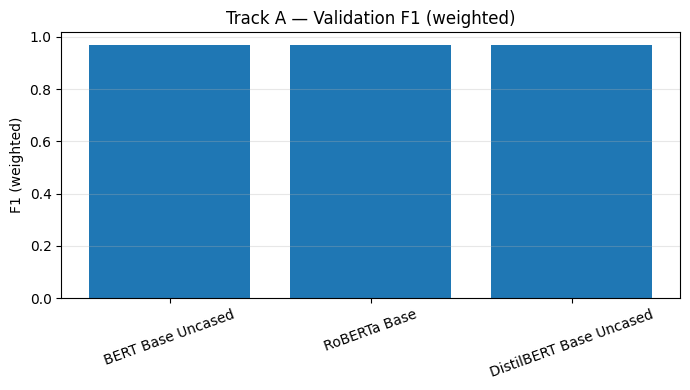

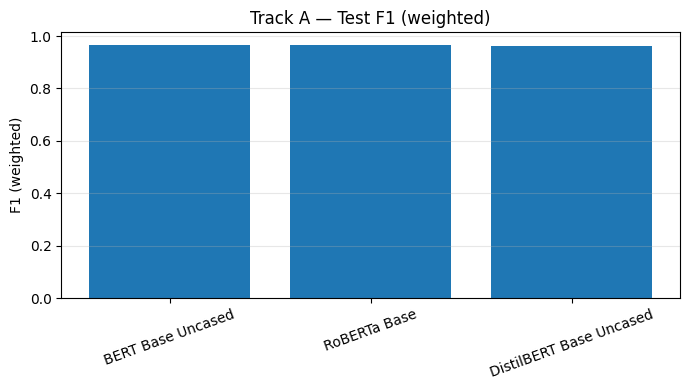

In [12]:
def summarize_best(df_table: pd.DataFrame) -> Dict[str, float]:
    last = df_table.sort_values("Epoch").tail(1).iloc[0]
    return {"val_loss": float(last["Validation Loss"]),
            "val_acc": float(last["Accuracy"]),
            "val_f1w": float(last["F1 Weighted"])}

summaryA = []
for m in MODELS:
    s = summarize_best(trackA_epoch_tables[m]); tm = trackA_test_metrics[m]
    summaryA.append({
        "model_name": PRETTY[m],
        "eval_accuracy": s["val_acc"],
        "eval_f1_weighted": s["val_f1w"],
        "eval_loss": s["val_loss"],
        "test_accuracy": tm["test_accuracy"],
        "test_f1_weighted": tm["test_f1_weighted"],
        "test_loss": tm["test_loss"],
    })
dfA = pd.DataFrame(summaryA).sort_values("eval_f1_weighted", ascending=False)
print("\n=== TRACK A: MODEL PERFORMANCE (Validation) ===")
print(dfA[["model_name","eval_accuracy","eval_f1_weighted","eval_loss"]].to_string(index=False))
print("\n=== TRACK A: MODEL PERFORMANCE (Test) ===")
print(dfA[["model_name","test_accuracy","test_f1_weighted","test_loss"]].to_string(index=False))

plt.figure(figsize=(7,4))
plt.bar(dfA["model_name"], dfA["eval_f1_weighted"])
plt.title("Track A — Validation F1 (weighted)")
plt.xticks(rotation=20); plt.ylabel("F1 (weighted)"); plt.grid(axis="y", alpha=0.3)
plt.tight_layout(); plt.savefig(os.path.join(OUT_A,"trackA_val_f1w.png"), dpi=140); plt.show()

plt.figure(figsize=(7,4))
plt.bar(dfA["model_name"], dfA["test_f1_weighted"])
plt.title("Track A — Test F1 (weighted)")
plt.xticks(rotation=20); plt.ylabel("F1 (weighted)"); plt.grid(axis="y", alpha=0.3)
plt.tight_layout(); plt.savefig(os.path.join(OUT_A,"trackA_test_f1w.png"), dpi=140); plt.show()

<h1> Step 8: TRACK A — Inference helper (THIRD) </h1>

In [6]:
from transformers import AutoTokenizer

def absa_infer_filtered_table(
    text, model_dir, aspects,
    min_conf: float = 0.60, min_margin: float = 0.20, top_k: Optional[int] = None,
    device: Optional[str] = None
):
    tok = AutoTokenizer.from_pretrained(model_dir, use_fast=True)
    mdl = AutoModelForSequenceClassification.from_pretrained(model_dir)
    if device is None: device = "cuda" if torch.cuda.is_available() else "cpu"
    mdl.to(device).eval()

    SEP = tok.sep_token or "[SEP]"
    targets = extract_targets(text)
    rows, batch, meta = [], [], []
    for t in targets:
        for a in aspects:
            s = f"Sentence: {text} {SEP} Target: {t} {SEP} Aspect: {a} {SEP} Task: classify sentiment for this target & aspect."
            batch.append(s); meta.append((t,a))
    if not batch:
        return pd.DataFrame(columns=["Aspect","Target Entity","Label","Confidence"])

    enc = tok(batch, return_tensors="pt", truncation=True, padding=True, max_length=256).to(device)
    with torch.no_grad():
        probs = torch.softmax(mdl(**enc).logits, dim=-1).cpu().numpy()

    for (t, a), p in zip(meta, probs):
        p_none = float(p[SENT2ID["none"]])
        best_lbl, best_conf = None, -1.0
        for lbl in ("positive","neutral","negative"):
            c = float(p[SENT2ID[lbl]])
            if c > best_conf: best_lbl, best_conf = lbl, c
        if best_conf >= min_conf and (best_conf - p_none) >= min_margin:
            rows.append({"Aspect": a, "Target Entity": t, "Label": best_lbl, "Confidence": round(best_conf,3)})

    df = pd.DataFrame(rows).sort_values("Confidence", ascending=False)
    if top_k is not None: df = df.head(top_k)
    return df.reset_index(drop=True)

In [7]:
# === Quick notebook inference ===

TEXTS = [
    "LOCATION1 is transforming and the prices will go up and up",
    "Along LOCATION1 there are lots of Electronics shops (independent ones)",
    "And LOCATION1 is ten mins direct on the tube to LOCATION2",
]

model_dir = trackA_best["roberta-base"]  # or "bert-base-uncased", "distilbert-base-uncased"

for i, t in enumerate(TEXTS):
    df = absa_infer_filtered_table(
        text=t,
        model_dir=model_dir,
        aspects=ASPECTS,
        min_conf=0.60,         # tweak if you want fewer/more aspects
        min_margin=0.20,       # requires best_label - p_none >= 0.20
        top_k=6                # show the top K rows by confidence (None = all rows)
    )
    print(f"\nText {i}: {t}")
    print(df.to_string(index=False) if not df.empty else "  (no confident aspects)")

NameError: name 'trackA_best' is not defined

<h1> <b> Step 9: Track B — Train → Save Best (FIRST) </b> </h1>

In [ ]:
flatB = to_absa_flat(raw, downsample_none=0.3)  # same preprocessing as Track A

trackB_best = {}
trackB_epoch_tables = {}
trackB_test_metrics = {}

for m in MODELS:
    print(f"\n[Track B] Training {PRETTY[m]} … (scratch)")
    encB, _ = pairwise_tokenize(flatB, tokenizer_name=m, max_len=256, num_proc=2)
    runnerB = ABSAClassifier(RunCfg(
        model_key=m,
        init_path=None,                 # <-- scratch
        out_root=OUT_B,
        epochs=3, batch_size=16, lr=2e-5,
        grad_accum=1,
        fp16=torch.cuda.is_available(), # good speedup on Colab GPU
        bf16=False
    ))
    val_table, test_metrics = runnerB.train(encB)
    trackB_best[m] = runnerB.best_dir
    trackB_epoch_tables[m] = val_table
    trackB_test_metrics[m] = test_metrics



[Track B] Training RoBERTa Base … (scratch)


Map (num_proc=2):   0%|          | 0/32653 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/11244 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/22548 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-417720563.py:132: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `LightweightTrainer.__init__`. Use `processing_class` instead.
  trainer = LightweightTrainer(


Step,Training Loss
500,0.361500
1000,0.216400
1500,0.176200
2000,0.157600
2500,0.130700
3000,0.127100
3500,0.114600
4000,0.118200
4500,0.087000
5000,0.080100


<h1> Step 10: Track B — Results (SECOND) </h1>

In [ ]:
def summarize_best(df_table: pd.DataFrame) -> Dict[str, float]:
    last = df_table.sort_values("Epoch").tail(1).iloc[0]
    return {
        "val_loss": float(last["Validation Loss"]),
        "val_acc": float(last["Accuracy"]),
        "val_f1w": float(last["F1 Weighted"]),
    }

summaryB = []
for m in MODELS:
    s = summarize_best(trackB_epoch_tables[m])
    tm = trackB_test_metrics[m]
    summaryB.append({
        "model_name": PRETTY[m],
        "eval_accuracy": s["val_acc"],
        "eval_f1_weighted": s["val_f1w"],
        "eval_loss": s["val_loss"],
        "test_accuracy": tm["test_accuracy"],
        "test_f1_weighted": tm["test_f1_weighted"],
        "test_loss": tm["test_loss"],
    })
dfB = pd.DataFrame(summaryB).sort_values("eval_f1_weighted", ascending=False)

print("\n=== TRACK B: MODEL PERFORMANCE (Validation) ===")
print(dfB[["model_name","eval_accuracy","eval_f1_weighted","eval_loss"]].to_string(index=False))
print("\n=== TRACK B: MODEL PERFORMANCE (Test) ===")
print(dfB[["model_name","test_accuracy","test_f1_weighted","test_loss"]].to_string(index=False))

# Plots
plt.figure(figsize=(7,4))
plt.bar(dfB["model_name"], dfB["eval_f1_weighted"])
plt.title("Track B — Validation F1 (weighted)")
plt.xticks(rotation=20); plt.ylabel("F1 (weighted)"); plt.grid(axis="y", alpha=0.3)
plt.tight_layout(); plt.savefig(os.path.join(OUT_B,"trackB_val_f1w.png"), dpi=140); plt.show()

plt.figure(figsize=(7,4))
plt.bar(dfB["model_name"], dfB["test_f1_weighted"])
plt.title("Track B — Test F1 (weighted)")
plt.xticks(rotation=20); plt.ylabel("F1 (weighted)"); plt.grid(axis="y", alpha=0.3)
plt.tight_layout(); plt.savefig(os.path.join(OUT_B,"trackB_test_f1w.png"), dpi=140); plt.show()

<h1> Step 11: Track B — Inference helper (THIRD) </h1>

In [ ]:
NEW_TEXTS = [
    "LOCATION1 is transforming and the prices will go up and up",
    "Along LOCATION1 there are lots of Electronics shops (independent ones)",
    "And LOCATION1 is ten mins direct on the tube to LOCATION2",
]

for m in MODELS:
    print(f"\n[Track B] Inference — {PRETTY[m]}  (best: {trackB_best[m]})")
    for i, t in enumerate(NEW_TEXTS):
        df = absa_infer_filtered_table(
            text=t,
            model_dir=trackB_best[m],
            aspects=ASPECTS,
            min_conf=0.60,
            min_margin=0.20,
            top_k=6
        )
        print(f"\nText {i}: {t}")
        print(df.to_string(index=False) if not df.empty else "  (no confident aspects)")

<h1> Step 10: FINAL COMPARISON (both tracks) </h1>

In [ ]:
dfA_comp = dfA[["model_name","test_accuracy","test_f1_weighted","test_loss"]].copy()
dfA_comp["track"] = "Track A"
dfB_comp = dfB[["model_name","test_accuracy","test_f1_weighted","test_loss"]].copy()
dfB_comp["track"] = "Track B"
dfBoth = pd.concat([dfA_comp, dfB_comp], ignore_index=True)

print("\n=== FINAL COMPARISON (TEST) ===")
print(dfBoth.sort_values(["model_name","track"]).to_string(index=False))

pivot = dfBoth.pivot(index="model_name", columns="track", values="test_f1_weighted").fillna(0.0)
ax = pivot.loc[[PRETTY[m] for m in MODELS]].plot(kind="bar", figsize=(8,4))
ax.set_title("Test F1 (weighted): Track A vs Track B")
ax.set_ylabel("F1 (weighted)"); ax.grid(axis="y", alpha=0.3)
plt.xticks(rotation=20); plt.tight_layout()
plt.savefig(os.path.join(ABSA_ROOT,"final_comparison_test_f1w.png"), dpi=140)
plt.show()

<h1> Step 11:  MODEL INDEX (for the Gradio app) </h1>

In [ ]:
MODEL_INDEX_PATH = os.path.join(ABSA_ROOT, "model_index.json")
index = {
    "absa": {
        "TrackA": { m: trackA_best[m] for m in MODELS },
        "TrackB": { m: trackB_best[m] for m in MODELS },
        "aspects": ASPECTS,
        "sentiments": SENTIMENTS
    },
    "imdb": IMDB_BEST  # your binary models
}
with open(MODEL_INDEX_PATH, "w") as f:
    json.dump(index, f, indent=2)
print(f"\n[OK] Wrote model index → {MODEL_INDEX_PATH}")

<h1> Step 9: TRACK B — (b) Results (CSV + accuracy bar on validation) </h1>

In [ ]:
# ============================================================
# TRACK B — (b) Results (CSV + accuracy bar on validation)
# ============================================================
trackB_rows = []
for m in MODELS:
    best_dir = trackB_best[m]
    encB_val = build_pairwise_from_flat(flat, tokenizer_name=m, max_len=320)[0]["validation"]
    eval_stats = evaluate_best(best_dir, encB_val)
    trackB_rows.append({
        "model_key": m,
        "eval_accuracy": eval_stats["eval_accuracy"],
        "eval_f1_weighted": eval_stats["eval_f1_weighted"],
        "eval_loss": eval_stats["eval_loss"],
        "model_size": count_params(best_dir)
    })

csvB, acc_png_B = save_model_performance_table("Track B", trackB_rows, OUT_B)

Map:   0%|          | 0/3396 [00:00<?, ? examples/s]

Map:   0%|          | 0/838 [00:00<?, ? examples/s]

Map:   0%|          | 0/1677 [00:00<?, ? examples/s]

/tmp/ipython-input-4244200942.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  tr = Trainer(model=mdl, args=args, eval_dataset=enc_val, tokenizer=tok, data_collator=coll, compute_metrics=metrics)


Map:   0%|          | 0/3396 [00:00<?, ? examples/s]

Map:   0%|          | 0/838 [00:00<?, ? examples/s]

Map:   0%|          | 0/1677 [00:00<?, ? examples/s]

/tmp/ipython-input-4244200942.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  tr = Trainer(model=mdl, args=args, eval_dataset=enc_val, tokenizer=tok, data_collator=coll, compute_metrics=metrics)


Map:   0%|          | 0/3396 [00:00<?, ? examples/s]

Map:   0%|          | 0/838 [00:00<?, ? examples/s]

Map:   0%|          | 0/1677 [00:00<?, ? examples/s]

/tmp/ipython-input-4244200942.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  tr = Trainer(model=mdl, args=args, eval_dataset=enc_val, tokenizer=tok, data_collator=coll, compute_metrics=metrics)



=== MODEL PERFORMANCE COMPARISON ===
             model_name  eval_accuracy  eval_f1_weighted  eval_loss  model_size
           RoBERTa Base       0.946301          0.946774   0.199104   124648708
      BERT Base Uncased       0.912888          0.913656   0.248472   109485316
DistilBERT Base Uncased       0.900955          0.901302   0.274653    66956548
[Track B] Saved table → /content/drive/MyDrive/ABSA/TrackB/model_performance_track_b.csv
[Track B] Saved accuracy bar → /content/drive/MyDrive/ABSA/TrackB/track_b_accuracy_bar.png


<h1> Step 10: TRACK B — (c) Inference (full predictions) </h1>

In [ ]:
# ============================================================
# TRACK B — (c) Inference (full predictions)
# ============================================================
for m in MODELS:
    print(f"\n[Track B] Inference — {PRETTY[m]}  (best: {trackB_best[m]})")
    preds = absa_infer_full(NEW_TEXTS, trackB_best[m], ASPECTS)
    for i, items in enumerate(preds):
        print(f"Text {i}: {NEW_TEXTS[i]}")
        for d in items[:10]:
            print(f"  {d['aspect']:18s} @ {d['target_entity']:10s} → {d['label']:7s}  (conf={d['confidence']:.3f})")



[Track B] Inference — RoBERTa Base  (best: /content/drive/MyDrive/ABSA/TrackB/roberta-base/classifier/best)
Text 0: LOCATION1 is transforming and the prices will go up and up
  nightlife          @ LOCATION1  → positive  (conf=0.997)
  multicultural      @ LOCATION1  → positive  (conf=0.996)
  green-nature       @ LOCATION1  → positive  (conf=0.995)
  touristy           @ LOCATION1  → positive  (conf=0.995)
  general            @ LOCATION1  → positive  (conf=0.993)
  price              @ LOCATION1  → negative  (conf=0.992)
  safety             @ LOCATION1  → negative  (conf=0.989)
  live               @ LOCATION1  → positive  (conf=0.988)
  dining             @ LOCATION1  → positive  (conf=0.981)
  quiet              @ LOCATION1  → negative  (conf=0.978)
Text 1: Along LOCATION1 there are lots of Electronics shops (independent ones)
  shopping           @ LOCATION1  → positive  (conf=0.998)
  nightlife          @ LOCATION1  → positive  (conf=0.998)
  general            @ LOCATION1  → p

<h1> Step 11: FINAL COMPARISON (optional) </h1>

In [ ]:
# ============================================================
# FINAL COMPARISON (optional)
# ============================================================
dfA = pd.read_csv(os.path.join(OUT_A, "model_performance_track_a.csv"))
dfB = pd.read_csv(os.path.join(OUT_B, "model_performance_track_b.csv"))

cmp = dfA.merge(dfB, on="model_name", suffixes=("_A","_B"))
print("\n=== FINAL COMPARISON (Validation) ===")
print(cmp[["model_name","eval_accuracy_A","eval_accuracy_B","eval_f1_weighted_A","eval_f1_weighted_B"]])

plt.figure(figsize=(9,4))
x = np.arange(len(cmp))
w = 0.35
plt.bar(x - w/2, cmp["eval_accuracy_A"], width=w, label="Track A (IMDb-init)")
plt.bar(x + w/2, cmp["eval_accuracy_B"], width=w, label="Track B (Scratch)")
plt.xticks(x, cmp["model_name"], rotation=10)
plt.ylabel("Accuracy")
plt.title("ABSA Validation — Accuracy (Best Checkpoints)")
plt.legend()
for i, v in enumerate(cmp["eval_accuracy_A"]):
    plt.text(x[i] - w/2, v+0.003, f"{v:.5f}", ha="center", va="bottom")
for i, v in enumerate(cmp["eval_accuracy_B"]):
    plt.text(x[i] + w/2, v+0.003, f"{v:.5f}", ha="center", va="bottom")
final_png = os.path.join(ABSA_ROOT, "final_accuracy_comparison.png")
plt.tight_layout(); plt.savefig(final_png, dpi=150); plt.close()
print(f"Saved final comparison plot → {final_png}")


=== FINAL COMPARISON (Validation) ===
                model_name  eval_accuracy_A  eval_accuracy_B  \
0             RoBERTa Base         0.924821         0.946301   
1        BERT Base Uncased         0.909308         0.912888   
2  DistilBERT Base Uncased         0.904535         0.900955   

   eval_f1_weighted_A  eval_f1_weighted_B  
0            0.925287            0.946774  
1            0.910394            0.913656  
2            0.905438            0.901302  
Saved final comparison plot → /content/drive/MyDrive/ABSA/final_accuracy_comparison.png


In [ ]:
import os, glob, pprint

def check_dir(path):
    print(f"\n[CHECK] {path}")
    if not os.path.isdir(path):
        print("  ✗ Not a directory or not found.")
        return
    files = sorted(os.listdir(path))
    print("  Files:", files)
    # Look for known weight files
    for fname in ["model.safetensors", "pytorch_model.bin", "tf_model.h5", "flax_model.msgpack"]:
        fp = os.path.join(path, fname)
        if os.path.isfile(fp):
            print(f"  ✓ Found weights: {fp} ({os.path.getsize(fp)} bytes)")
    # If nothing at top-level, search a few levels
    print("  Searching up to 3 levels for weights…")
    for root, dirs, files in os.walk(path):
        depth = root.count(os.sep) - path.count(os.sep)
        if depth > 3:
            dirs[:] = []
            continue
        for fname in ["model.safetensors", "pytorch_model.bin", "tf_model.h5", "flax_model.msgpack"]:
            fp = os.path.join(root, fname)
            if os.path.isfile(fp):
                print(f"  ✓ Found weights at: {fp} ({os.path.getsize(fp)} bytes)")

check_dir("/content/drive/MyDrive/bert_imdb_sentiment_analysis/models/roberta-base/best_model")
check_dir("/content/drive/MyDrive/bert_imdb_sentiment_analysis/models/bert-base-uncased/best_model")
check_dir("/content/drive/MyDrive/bert_imdb_sentiment_analysis/models/distilbert-base-uncased/best_model")



[CHECK] /content/drive/MyDrive/bert_imdb_sentiment_analysis/models/roberta-base/best_model
  Files: ['config.json', 'merges.txt', 'model.safetensors', 'special_tokens_map.json', 'tokenizer.json', 'tokenizer_config.json', 'vocab.json']
  ✓ Found weights: /content/drive/MyDrive/bert_imdb_sentiment_analysis/models/roberta-base/best_model/model.safetensors (498612824 bytes)
  Searching up to 3 levels for weights…
  ✓ Found weights at: /content/drive/MyDrive/bert_imdb_sentiment_analysis/models/roberta-base/best_model/model.safetensors (498612824 bytes)

[CHECK] /content/drive/MyDrive/bert_imdb_sentiment_analysis/models/bert-base-uncased/best_model
  Files: ['config.json', 'model.safetensors', 'special_tokens_map.json', 'tokenizer.json', 'tokenizer_config.json', 'vocab.txt']
  ✓ Found weights: /content/drive/MyDrive/bert_imdb_sentiment_analysis/models/bert-base-uncased/best_model/model.safetensors (437958648 bytes)
  Searching up to 3 levels for weights…
  ✓ Found weights at: /content/drive

In [ ]:
import os, json

ROOT = "/content/drive/MyDrive"   # adjust if you mounted to a different place

WEIGHTS = {"model.safetensors", "pytorch_model.bin", "tf_model.h5", "flax_model.msgpack"}
EXTRA = {"config.json", "tokenizer.json", "tokenizer_config.json", "vocab.txt", "vocab.json", "merges.txt"}

candidates = []
for root, dirs, files in os.walk(ROOT):
    files = set(files)
    if WEIGHTS & files:
        if "config.json" in files:  # sanity: this is likely a checkpoint
            candidates.append(root)

print("Found candidate checkpoints:")
for i, p in enumerate(sorted(candidates)):
    print(f"{i:2d}  {p}")


Found candidate checkpoints:
